# Gurobi example notebook

In this notebook, we go through the formulation of a small test network using the Gurobi modelling interface.

In [2]:
import tensorflow as tf
import numpy as np
import gurobipy as grb

from relumip.ann_model import AnnModel
from relumip.utils.visualization import plot_results_2d

ModuleNotFoundError: No module named 'relumip'

First, we need to load the trained tensorflow model which we want to embed into an optimization problem. Here, a network with 5 layers, 5 neurons each was trained on data generated by the [peaks](https://www.mathworks.com/help/matlab/ref/peaks.html) test function. Our goal will be to find the global minimum of this function by minimizing the output of the  trained ANN.

In [2]:
tf_model = tf.keras.models.load_model('examples/peaks_3x10.h5')

Now, we create a `gurobi` model and a block which will contain the ANN.

In [3]:
opt_model = grb.Model()


--------------------------------------------
--------------------------------------------

Academic license - for non-commercial use only


Before generating the ANN formulation, we need to specify the input and output variables of our network. Here, the network input is two-dimensional and the network output is one-dimensional. In order to arrive at a tight optimization formulation of our network, the variable bounds of the network input **have to be defined**. For the *peaks* data set, both input variables have lower bound -3 and upper bound 3. Note that these bounds can not be inferred from the tensorflow model and thus have to be known by the user (the bounds can be computed from the data used to train the ANN, for example). For the output variables, bounds can be defined loosely or not at all.

In [4]:
input_vars = [opt_model.addVar(-3, 3, vtype=grb.GRB.CONTINUOUS), 
              opt_model.addVar(-3, 3, vtype=grb.GRB.CONTINUOUS)]
output_vars = [opt_model.addVar(-grb.GRB.INFINITY, grb.GRB.INFINITY, vtype=grb.GRB.CONTINUOUS, name='output')]
opt_model.update()

A AnnModel instance can be created by specifying the underlying tensorflow model and the desired modeling language. Then, the user-defined ANN input and output variables are linked to the AnnModel. Note that both have to be passed in list form.

In [5]:
ann_model = AnnModel(tf_model=tf_model, modeling_language='GUROBI')

ann_model.connect_network_input(opt_model, input_vars)
ann_model.connect_network_output(opt_model, output_vars)

After all the relevant information has been defined, the network formulation can now be created and embedded in the model.ann Block.  There diffenrent bound tightening options for the pyomo interface: 'MIP' and 'LP'. 'MIP' will produce the optimal bounds for each node in the network, but can be quite time consuming for larger networks. 'LP' solves relaxed sub-problems during bound tightening, which results in weaker bounds but is less time intensive

In [6]:
ann_model.embed_network_formulation(bound_tightening_strategy='LP')

Evaluating node (4,0): : 21it [00:00, 344.91it/s]                                                                      

Parameter LogToConsole unchanged
   Value: 1  Min: 0  Max: 1  Default: 1


The constraints and variables describing the network have now been added to the model. We can continue to build our model using the input and output variables defined above. In this simple example, we don't wish to add any additional constraints or variables, but elect to minimize the output of our ANN. This is equivalent to finding the global optimum of out network function, and thereby also approximating the global optimum of the *peaks* function (the quality of this approximation depends on the quality of the underlying tensorflow model). Thus, we set the objective of out model equal to the output of the embedded ANN and solve.

In [7]:
opt_model.setObjective(output_vars[0], grb.GRB.MINIMIZE)
opt_model.optimize()

Optimize a model with 91 rows, 63 columns and 601 nonzeros
Variable types: 33 continuous, 30 integer (30 binary)
Coefficient statistics:
  Matrix range     [3e-03, 4e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [7e-01, 5e+01]
  RHS range        [5e-03, 4e+01]
Presolve time: 0.00s
Presolved: 91 rows, 63 columns, 601 nonzeros
Variable types: 33 continuous, 30 integer (30 binary)

Root relaxation: objective -2.176268e+01, 78 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  -21.76268    0   15          -  -21.76268      -     -    0s
     0     0  -20.96553    0   13          -  -20.96553      -     -    0s
H    0     0                       1.6067886  -20.96553  1405%     -    0s
H    0     0                       0.2505943  -20.96553  8466%     -    0s
     0     0  -20.94593    0   13    0.25059  -20.94593  8459%     -    0s
     0   

We can display our full `Gurobi` model to get a sense its structure. We see that the ANN nodes are organized as indexed blocks. Each block describing a hidden node contains one variable equivalent to the node output (*x*), and one binary variable indicating wether the node is active or not (*z*). Additionally, each node contains three constraints encoding the ReLU activation function. The constraints are stored in ConstrainLists of the ANN block.

In [8]:
opt_model.display()

Minimize
   <gurobi.LinExpr: output>
Subject To
   R0 : <gurobi.LinExpr: -0.06521996110677719 C0 + -0.3717099130153656 C1 + ANN_x_10> >= -0.5822945237159729
   R1 : <gurobi.LinExpr: -0.06521996110677719 C0 + -0.3717099130153656 C1 + ANN_x_10 + 1.8930841460824013 ANN_z_10> <= 1.3107896223664284
   R2 : <gurobi.LinExpr: ANN_x_10 + -0.7284950986504555 ANN_z_10> <= 0.0
   R3 : <gurobi.LinExpr: 1.2685320377349854 C0 + -0.25481683015823364 C1 + ANN_x_11> >= -0.4744788706302643
   R4 : <gurobi.LinExpr: 1.2685320377349854 C0 + -0.25481683015823364 C1 + ANN_x_11 + 5.044525474309921 ANN_z_11> <= 4.570046603679657
   R5 : <gurobi.LinExpr: ANN_x_11 + -4.095567733049393 ANN_z_11> <= 0.0
   R6 : <gurobi.LinExpr: 1.2804434299468994 C0 + 1.879337191581726 C1 + ANN_x_12> >= -0.14776574075222015
   R7 : <gurobi.LinExpr: 1.2804434299468994 C0 + 1.879337191581726 C1 + ANN_x_12 + 9.627107605338097 ANN_z_12> <= 9.479341864585876
   R8 : <gurobi.LinExpr: ANN_x_12 + -9.331576123833656 ANN_z_12> <= 0.0
   R9 :

   R76 : <gurobi.LinExpr: -0.7674122452735901 ANN_x_20 + 1.6825281381607056 ANN_x_21 + 1.4198203086853027 ANN_x_22 + -0.5456273555755615 ANN_x_23 + -0.3463227450847626 ANN_x_24 + 0.04807046428322792 ANN_x_25 + 1.002120018005371 ANN_x_26 + 1.1283392906188965 ANN_x_27 + -0.3949449062347412 ANN_x_28 + -0.09948697686195374 ANN_x_29 + ANN_x_35 + 36.35956036840789 ANN_z_35> <= 36.79274529014938
   R77 : <gurobi.LinExpr: ANN_x_35 + -7.920159077236799 ANN_z_35> <= 0.0
   R78 : <gurobi.LinExpr: 0.29141032695770264 ANN_x_20 + -0.22261838614940643 ANN_x_21 + 0.10449030250310898 ANN_x_22 + -0.7790359854698181 ANN_x_23 + 1.6632136106491089 ANN_x_24 + 0.8824605941772461 ANN_x_25 + -0.2703835666179657 ANN_x_26 + 1.3828377723693848 ANN_x_27 + 0.2980419397354126 ANN_x_28 + 0.32514092326164246 ANN_x_29 + ANN_x_36> >= 0.26024702191352844
   R79 : <gurobi.LinExpr: 0.29141032695770264 ANN_x_20 + -0.22261838614940643 ANN_x_21 + 0.10449030250310898 ANN_x_22 + -0.7790359854698181 ANN_x_23 + 1.6632136106491089

To visualize the computed solution, we can evaluate the tensorflow model on a set of random points within the domain defined by the ANN input variables. The solution point computed by the above optimization problem is extracted from the model and displayed as a red dot on the plot. Evidently, it is located at the minimum of the network output.

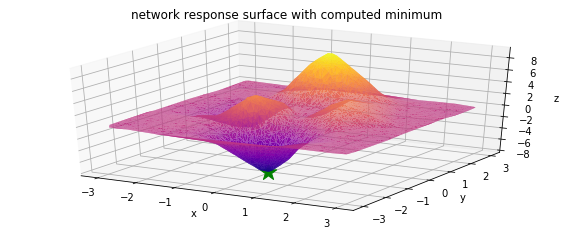

In [16]:
sample_input = 6 * np.random.rand(10000, 2) - 3
sample_output = tf_model.predict(sample_input)
sol_point = [input_vars[0].getAttr(grb.GRB.Attr.X),
             input_vars[1].getAttr(grb.GRB.Attr.X),
             output_vars[0].getAttr(grb.GRB.Attr.X)]
plot_results_2d(sample_input, sample_output, sol_point=sol_point)

This concludes our illustrative example. Of course, more complex models can be defined using this package. Network input and output variables can be embedded in larger optimization problems and multiple ANNs can be embedded to model multiple nonlinear components of a complex system. 